In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import skimage, os
# from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
# from skimage.measure import label,regionprops, perimeter
# from skimage.morphology import binary_dilation, binary_opening
# from skimage.filters import roberts, sobel
# from skimage import measure, feature
# from skimage.segmentation import clear_border
# from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import scipy.misc
import os
import nibabel
import numpy as np
from glob import glob
# from skimage.io import imread
# os.path.join('..','input')

In [2]:
BASE_IMG_PATH = '/home/usman/Desktop/Datasets/dldirect_results'
glob(os.path.join(BASE_IMG_PATH,'T1w','*'))

[]

In [3]:
# show some of the files
all_images=glob(os.path.join(BASE_IMG_PATH,'*.gz'))
# all_masks = [x.replace('IMG_', 'MASK_') for x in all_images]
print(len(all_images))

4


<function matplotlib.pyplot.show(close=None, block=None)>

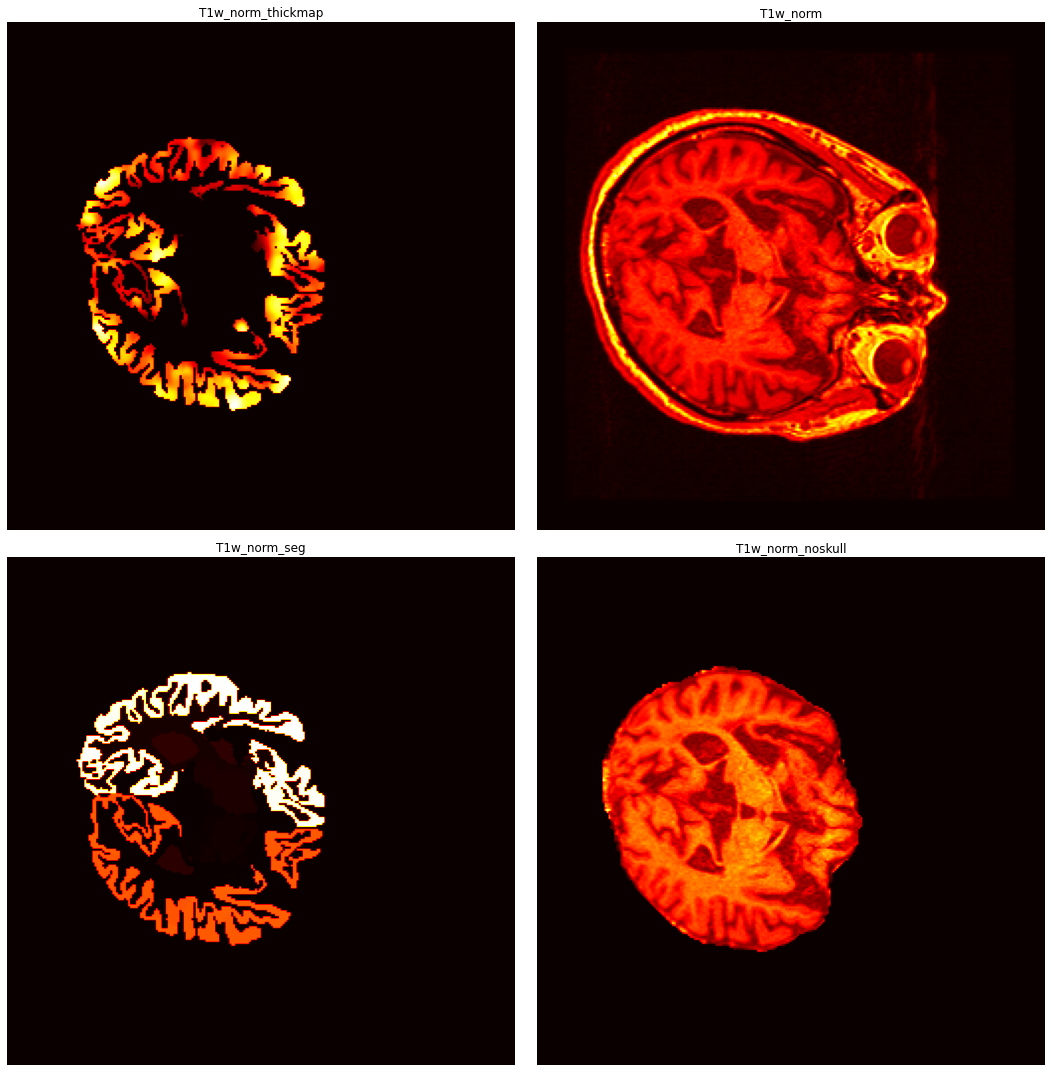

In [17]:
%matplotlib inline
import nibabel as nib
from pathlib import Path
col = 2
row = 2
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=[15, 15])
# fig = plt.figure(figsize = (15, 15))
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
for i  in range(len(all_images)):
    img = nib.load(all_images[i]).get_fdata()
    # fig.add_subplot(row, col, i)
    ax.ravel()[i].imshow(img[:,130,:], cmap="hot")
    # pth = 
    ax.ravel()[i].set_title(Path(all_images[i]).with_suffix('').stem)
    ax.ravel()[i].axis('off')
    # ax.get_xaxis().set_visible(False)
plt.tight_layout()
# plt.axis('off')
plt.show


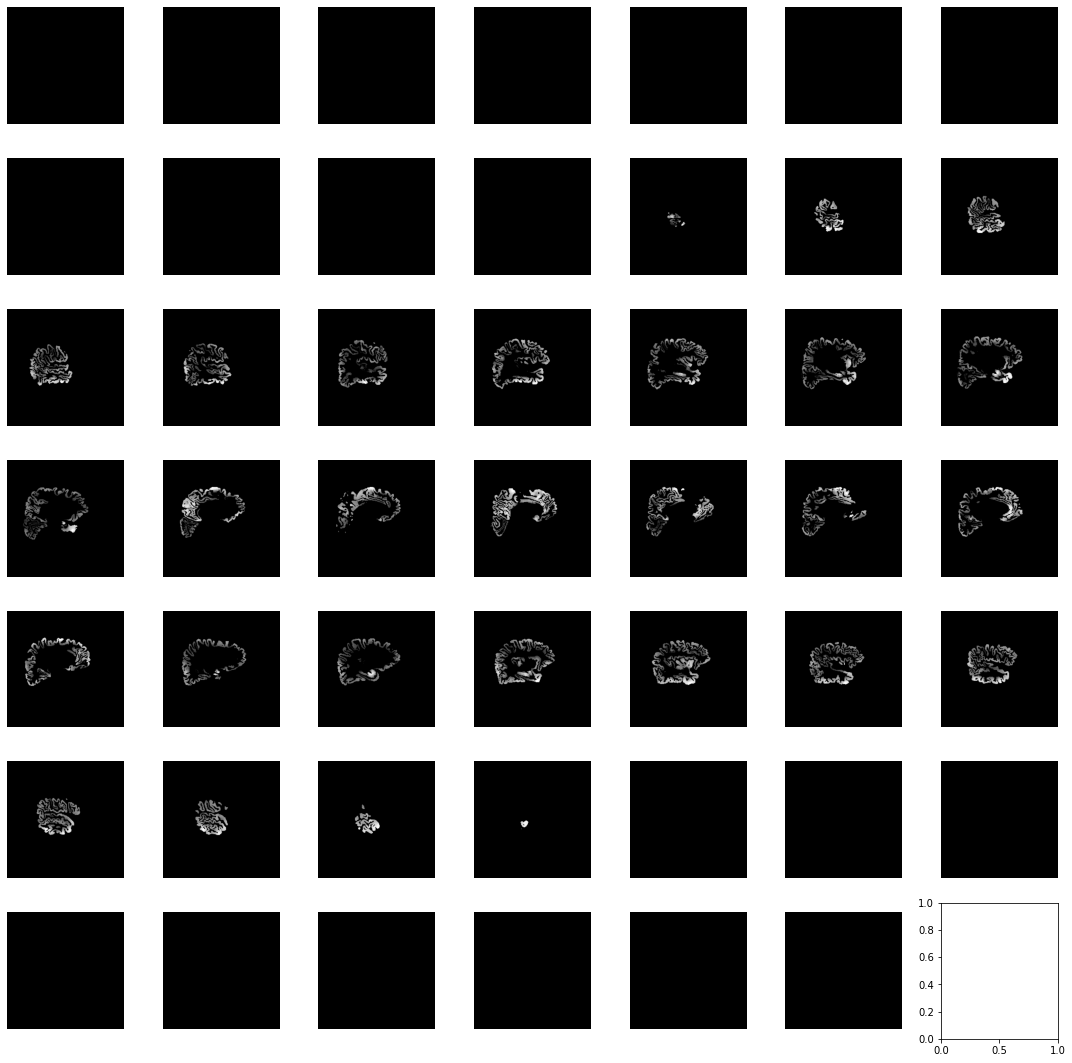

In [10]:
brain_vol = nib.load(all_images[0]).get_fdata()
fig_rows = 7
fig_cols = 7
n_subplots = fig_rows * fig_cols
n_slice = brain_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[15, 15])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(brain_vol[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from scipy.ndimage import binary_dilation

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines


hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')
t1_fname = get_fnames('stanford_t1')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
t1_data = load_nifti_data(t1_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)
# We’ve loaded an image called labels_img which is a map of tissue types such that every integer value in the array labels represents an anatomical structure or tissue type 1. For this example, the image was created so that white matter voxels have values of either 1 or 2. We’ll use peaks_from_model to apply the CsaOdfModel to each white matter voxel and estimate fiber orientations which we can use for tracking. We will also dilate this mask by 1 voxel to ensure streamlines reach the grey matter.

white_matter = binary_dilation((labels == 1) | (labels == 2))
csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=data,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=white_matter)
# Now we can use EuDX to track all of the white matter. To keep things reasonably fast we use density=1 which will result in 1 seeds per voxel. The stopping criterion, determining when the tracking stops, is set to stop when the tracking exits the white matter.

affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                     affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)
# The first of the tracking utilities we’ll cover here is target. This function takes a set of streamlines and a region of interest (ROI) and returns only those streamlines that pass through the ROI. The ROI should be an array such that the voxels that belong to the ROI are True and all other voxels are False (this type of binary array is sometimes called a mask). This function can also exclude all the streamlines that pass through an ROI by setting the include flag to False. In this example we’ll target the streamlines of the corpus callosum. Our labels array has a sagittal slice of the corpus callosum identified by the label value 2. We’ll create an ROI mask from that label and create two sets of streamlines, those that intersect with the ROI and those that don’t.

cc_slice = labels == 2
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, cc_slice,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)
# We can use some of DIPY’s visualization tools to display the ROI we targeted above and all the streamlines that pass through that ROI. The ROI is the yellow region near the center of the axial image.



In [2]:
from dipy.viz import window, actor, colormap as cmap

# Enables/disables interactive visualization
interactive = False

# Make display objects
color = cmap.line_colors(cc_streamlines)
cc_streamlines_actor = actor.line(cc_streamlines,
                                  cmap.line_colors(cc_streamlines))
cc_ROI_actor = actor.contour_from_roi(cc_slice, color=(1., 1., 0.),
                                      opacity=0.5)

vol_actor = actor.slicer(t1_data)

vol_actor.display(x=40)
vol_actor2 = vol_actor.copy()
vol_actor2.display(z=35)

# Add display objects to canvas
scene = window.Scene()
scene.add(vol_actor)
scene.add(vol_actor2)
scene.add(cc_streamlines_actor)
scene.add(cc_ROI_actor)

In [ ]:

# Save figures
window.record(scene, n_frames=1, out_path='corpuscallosum_axial.png',
              size=(800, 800))
if interactive:
    window.show(scene)
scene.set_camera(position=[-1, 0, 0], focal_point=[0, 0, 0], view_up=[0, 0, 1])
window.record(scene, n_frames=1, out_path='corpuscallosum_sagittal.png',
              size=(800, 800))
if interactive:
    window.show(scene)


: 

: 